In [1]:
import datetime as dt
import os, sys
import netCDF4 as nc
import matplotlib as mpl
import numpy as np
import numpy.ma as ma
from scipy.spatial import distance
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import cm
import matplotlib.colors as mpl_colors
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable


from salishsea_tools import geo_tools, viz_tools

get_ipython().magic('matplotlib inline')

In [2]:
#Parameters

cmap = plt.get_cmap('nipy_spectral')
cmap.set_bad('burlywood')

H = 24 #One day in hours

#Ariane parameters
tunit= 3600

outint = 20 * 60 # 20 min in seconds

pph = int(tunit / outint) #points per hour

lmt = 1896 #points per particle


#RUN parameters

nday= 50

plotsdir = "/ocean/gsgarbi/analysis-giorgio/time_series/results2016/plots"


position = nday * pph * H # d * num/h * h/d = num

In [3]:
#function to get points from an indiviual month

def getpts(direct):
    
    points = []
    
    particle = 1 #start particle counter
    
    start = dt.datetime.now()
    print ("start {}: ".format(direct), start)


    with open(direct + "/traj.txt") as file:

        for i, line in enumerate(file):

            line = line.strip('\n').split()

            line = [float(k) for k in line]

            line = np.array(line)


            if line[0] == particle:
                index = i + position
                particle += 1

            if i == index:
                points.append (line)
                
        print ("time: ", dt.datetime.now() - start)
                
                
    return points

In [4]:
# test cell

# jan = get_pts("/ocean/gsgarbi/analysis-giorgio/time_series/results2016/20160101_20160131_427d/")

#feb = get_pts("/ocean/gsgarbi/analysis-giorgio/time_series/results2016/20160201_20160229_401d/")

In [5]:
# Get points for the year - this process should take about 42min for 12 months (3.5min per month)

path = "/ocean/gsgarbi/analysis-giorgio/time_series/results2016/"

dirs = os.listdir( path )

year = []


for file in dirs:
    year += getpts(path + file)
    


start /ocean/gsgarbi/analysis-giorgio/time_series/results2016/20160201_20160229_401d:  2017-04-11 14:47:22.474384
time:  0:03:18.457162
start /ocean/gsgarbi/analysis-giorgio/time_series/results2016/20160401_20160430_325d:  2017-04-11 14:50:40.931962
time:  0:02:49.995328
start /ocean/gsgarbi/analysis-giorgio/time_series/results2016/20161101_20161130_111d:  2017-04-11 14:53:30.927712
time:  0:00:56.673852
start /ocean/gsgarbi/analysis-giorgio/time_series/results2016/20160101_20160131_427d:  2017-04-11 14:54:27.602045
time:  0:03:40.300786
start /ocean/gsgarbi/analysis-giorgio/time_series/results2016/20160601_20160630_264d:  2017-04-11 14:58:07.903191
time:  0:02:10.748445
start /ocean/gsgarbi/analysis-giorgio/time_series/results2016/20160901_20160930_172d:  2017-04-11 15:00:18.652003
time:  0:01:24.049664
start /ocean/gsgarbi/analysis-giorgio/time_series/results2016/20161001_20161031_141d:  2017-04-11 15:01:42.702167
time:  0:01:11.335887
start /ocean/gsgarbi/analysis-giorgio/time_serie

NotADirectoryError: [Errno 20] Not a directory: '/ocean/gsgarbi/analysis-giorgio/time_series/results2016/plot100days.png/traj.txt'

start:  2017-04-14 12:44:52.285900
time:  0:00:34.005660


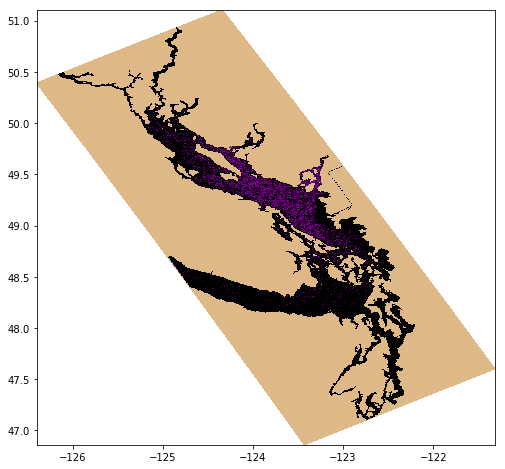

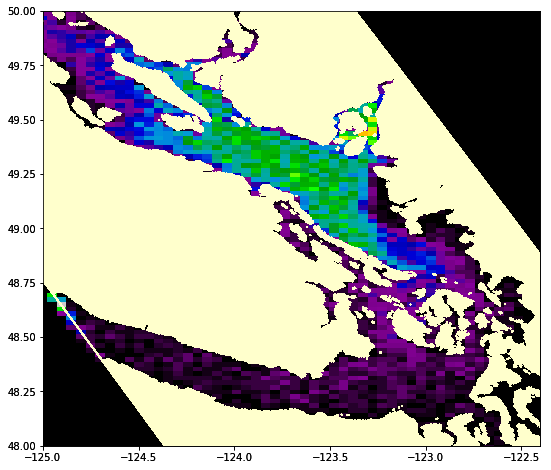

In [18]:
#prepare plot

points = np.array(year) #back to original name. convert to np.array

start = dt.datetime.now()
print ("start: ", start)


# In[7]:



np.shape(points)


# In[8]:

# set up array of zeros of shape of model domain; also load tmask, model lons and lats
mesh = nc.Dataset("/ocean/gsgarbi/mesh_mask_downbyone2.nc")
tmask=np.copy(mesh.variables['tmask'])
mesh.close()
fb=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
nav_lon=np.copy(fb.variables['nav_lon'])
nav_lat=np.copy(fb.variables['nav_lat'])
fb.close()


# In[9]:

tmask.shape


# In[10]:

griddata=0.0*tmask[0,0,:,:]
griddata.shape


# In[11]:

np.shape(points)[0]


# In[12]:

for ii in range(0,np.shape(points)[0]):
    j,i=geo_tools.find_closest_model_point(points[ii,1],points[ii,2],nav_lon,nav_lat)
    #print(points[ii,1],points[ii,2],j,i)
    griddata[j,i]=griddata[j,i]+1


# In[13]:

fig, axs = plt.subplots(1,1,figsize=(9,8))
mesh0 = axs.pcolormesh(nav_lon,nav_lat,np.ma.masked_where(tmask[0,0,:,:]==0,griddata),cmap=cmap)

viz_tools.set_aspect(axs,coords='map')


# In[14]:

# model grid is too small. use hist2d for larger bins, then overlay grid


# In[15]:

lonlim=[np.min(nav_lon),np.max(nav_lon)]
latlim=[np.min(nav_lat),np.max(nav_lat)]

griddata, iedges, jedges = np.histogram2d(points[:,1],points[:,2],bins=[100,200],range=[lonlim,latlim])


# In[16]:

Jedges,Iedges=np.meshgrid(jedges,iedges)


# In[17]:

Jedges.shape


# In[18]:

griddata.shape


# In[19]:

xl=(-125,-122.4)
yl=(48,50)
fig, axs = plt.subplots(1,1,figsize=(9,8))
mesh0 = axs.pcolormesh(Iedges,Jedges,griddata,cmap=cmap)
axs.set_xlim(xl)
axs.set_ylim(yl)
#axs.plot(-124.0,49.5,'r*')
viz_tools.set_aspect(axs,coords='map')
pos=axs.get_position()
axs2 = plt.axes(pos)
mesh1=axs2.pcolormesh(nav_lon,nav_lat,np.ma.masked_where(tmask[0,0,:,:]==1,tmask[0,0,:,:]),cmap='YlOrRd')
axs2.set_xlim(xl)
axs2.set_ylim(yl)
axs2.patch.set_alpha(0)
viz_tools.set_aspect(axs2,coords='map')


print ("time: ", dt.datetime.now() - start)



1.1363636363636362

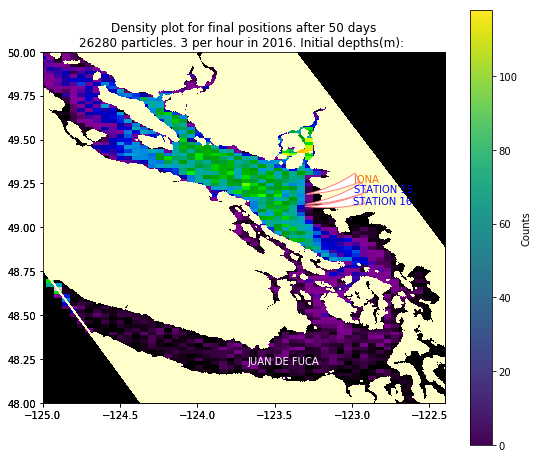

In [9]:
#plot


plt.clf()

Iona = (-123.30898284912109, 49.187351226806641)
S15 = (-123.3114, 49.130412)
S16 = (-123.317415, 49.1214)


lonlim=[np.min(nav_lon),np.max(nav_lon)]
latlim=[np.min(nav_lat),np.max(nav_lat)]

griddata, iedges, jedges = np.histogram2d(points[:,1],points[:,2],bins=[100,200],range=[lonlim,latlim])




Jedges,Iedges=np.meshgrid(jedges,iedges)




Jedges.shape




griddata.shape




xl=(-125,-122.4)
yl=(48,50)
fig, axs = plt.subplots(1,1,figsize=(9,8))



mesh0 = axs.pcolormesh(Iedges,Jedges,griddata,cmap=cmap)

#-----------


# Make plot with vertical (default) colorbar


data = griddata

cax = axs.imshow(data, interpolation='nearest')
axs.set_title("Density plot for final positions after {} days\n".format(nday) +
          "26280 particles. 3 per hour in 2016. Initial depths(m): ")

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax)
  # vertically oriented colorbar
    
cbar.set_label ("Counts")

#------------

axs.set_xlim(xl)
axs.set_ylim(yl)
#axs.plot(-124.0,49.5,'r*')
viz_tools.set_aspect(axs,coords='map')

pos=axs.get_position()
axs2 = plt.axes(pos)
mesh1=axs2.pcolormesh(nav_lon,nav_lat,np.ma.masked_where(tmask[0,0,:,:]==1,tmask[0,0,:,:]),cmap='YlOrRd')



axs2.set_xlim(xl)
axs2.set_ylim(yl)
axs2.patch.set_alpha(0)


el = Ellipse((2, -1), 0.5, 0.5)

axs2.annotate(
        "IONA",
        xy=(Iona[0], Iona[1]), xytext=(50, 10),
        textcoords='offset points', ha='left', va='bottom', color = (0.937, 0.439, 0.043),
        arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  fc=(1,1,1), ec=(1., .5, .5),
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1"))


axs2.annotate(
        "STATION 15",
        xy=(S15[0],S15[1]), xytext=(50, 10),
            textcoords='offset points', ha='left', va='bottom', color = "blue",
        #bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  fc=(1,1,1), ec=(1., .5, .5),
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1"))

axs2.annotate(
        "STATION 16",
        xy=(S16[0],S16[1]), xytext=(50, 10),
        textcoords='offset points', ha='left', va='top', color = 'blue',
        #bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                          arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  fc=(1,1,1), ec=(1., .5, .5),
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1"))



axs2.annotate(
        "JUAN DE FUCA",
        xy=(-124,48.21), xytext=(50, 10),
        textcoords='offset points', ha='left', va='top', color = 'white')

viz_tools.set_aspect(axs2,coords='map')

In [10]:
#save plots (50 or 100 for now)

fig.savefig(plotsdir + "/plot{}days".format(nday))